In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pergrid_base_combined_predicted = '/Users/lianfeng/Document/species_richness_sdm/src/notebooks/machine_learning/manuscript1/output/pergrid_base_combined_predicted.csv'

In [3]:
pergrid_all_predicted = pd.read_csv(pergrid_base_combined_predicted, sep=",")

In [4]:
pergrid_all_predicted.columns

Index(['grid_id', 'grid_id.1', 'tsr', 'tsr_predicted'], dtype='object')

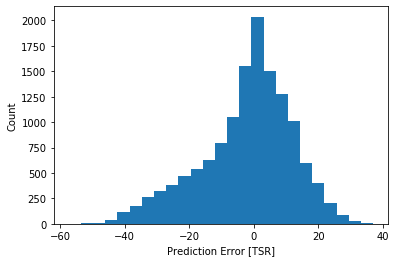

In [5]:
error = pergrid_all_predicted['tsr_predicted'] - pergrid_all_predicted['tsr']
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [TSR]")
_ = plt.ylabel("Count")

In [6]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pergrid_all_predicted['tsr_predicted'], pergrid_all_predicted['tsr'])

10.904348650342369

In [12]:
pergrid_all_predicted = pd.DataFrame(
    {'grid_id': pergrid_all_predicted['grid_id'].to_list(),
     'tsr': pergrid_all_predicted['tsr'].to_list(),
     'tsr_predicted': pergrid_all_predicted['tsr_predicted'].to_list()})

In [15]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))

In [16]:
pergrid_all_predicted.to_sql(name='m5_base_combined', con=engine, schema='predictor', if_exists='replace', index=False)

In [17]:
update_geom = """
alter table predictor.m5_base_combined add column if not exists wkb_geometry geometry(Polygon,4269);
update predictor.m5_base_combined A SET wkb_geometry = B.wkb_geometry
FROM predictor.pergrid_base B
WHERE A.grid_id = B.grid_id
"""

In [18]:
connection = engine.connect()
connection.execute(update_geom)

In [19]:
update_residual = """
alter table predictor.m5_base_combined add column residual double precision;
update predictor.m5_base_combined set residual = (tsr_predicted-tsr);
"""

In [20]:
connection = engine.connect()
connection.execute(update_residual)